In [ ]:
# ! pip install --user --upgrade scipy numba
# ! pip install --user psutil

In [1]:
import os

os.environ['NUMBA_DISABLE_JIT'] = '1'

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import numpy as np
import seaborn as sns
from joblib import Parallel, delayed

from trees import TransferTreeRegressor, build_tree, Node
from simulation import generate_data, split_out_dat
from criteria import mse, transfer, causal_tree_criterion


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 2.5]

In [12]:
from trees import Leaf
leaf = Leaf(0,0,0,0)

def plot_split(node, X, tau, context_idxs):
    idx = X[:, node.dim] > node.thresh
    d = np.vstack([tau, idx, context_idxs]).T
    df = pd.DataFrame(d, columns = ['tau', 'split', 'ctx'])

    for _, d in df.groupby('split'):
        v = d.groupby('ctx').mean().tau.values
        print(d.groupby('ctx').mean().tau.values)
    # sns.distplot(df)
    g = sns.FacetGrid(df, row = 'split', hue = 'ctx', aspect=5.0)
    g.map(sns.distplot, 'tau', bins=10, kde=False)
    plt.legend()

In [226]:
from sklearn.metrics import mean_squared_error, r2_score
from simulation import Dataset
from collections import namedtuple
from copy import deepcopy

Results = namedtuple('Results', ['mse', 'r2', 'predictions', 'data', 'model', 'model_name'])

def fit_model(model, dat: Dataset):
    model_name, model, fit_fn = model
    model = deepcopy(model)
    model.fit(**fit_fn(dat))

    preds = model.predict(dat.phi.target, 0.95)

    mse = mean_squared_error(dat.tau.target, preds[:, 0])
    r2 = r2_score(dat.tau.target, preds[:, 0])    

    return Results(mse, r2, preds, dat, model, model_name)

In [227]:
import pandas as pd

def stats_df(dat):
    return pd.DataFrame(dat, columns=['value', 'model'])

def pipe(*fns):
    def fn(res):
        for f in fns:
            res = f(res)
        return res
    return lambda f: lambda *a, **k: fn(f(*a, **k))

def plot_dist(df, **kwargs):
    for model, df in df.groupby('model'):
        sns.distplot(df.value, label=model, **kwargs)
    plt.legend()
    plt.show()


def _get_within_ci(preds, taus):
    return pd.DataFrame(preds, columns = ['pred', 'lower', 'upper']) \
             .assign(true = taus) \
             .groupby('pred') \
             .apply(lambda df: df.assign(true_cate = df.true.mean())) \
             .pipe(lambda df: df.assign(within_int = \
                                        (df.true_cate <= df.upper) & \
                                        (df.true_cate >= df.lower))) \
             .pipe(lambda df: df['within_int'].sum() / df.shape[0])


@pipe(stats_df)
def compare(fn, baseline, vals):
    comp = lambda a,b: (a-b)/b

    bs = [fn(m) for v in vals for m in v if m.model_name == baseline]

    return [(comp(fn(m), b), m.model_name)
            for v, b in zip(vals, bs)
            for m in v
            if m.model_name != baseline]


@pipe(stats_df)
def pick(fn, results):
    return [(fn(m), m.model_name) for v in results for m in v]

def compare_cis(results):
    fn = lambda m: _get_within_ci(m.predictions, m.data.tau.target)
    return pick(fn, results)

def r_squared(results):
    tau_var = lambda r: np.mean((np.mean(r.data.tau.target) - r.data.tau.target)**2)
    return pick(lambda m: 1 - m.mse/tau_var(m), results)

def plot_and_print(df, **kwargs):
    plot_dist(df, **kwargs)
    print(df.groupby('model').mean())

In [228]:
# Y := f(H, W, X, Z, N_Y)
# Y := f(W, X, Z, N_Y)

def runrun(models, **kwargs):
    dat = generate_data(**{**kwargs, 'plot': False})
    return [fit_model(model, split_out_dat(dat)) for model in models]

def data_check(**kwargs):
    generate_data(**{**kwargs, 'plot': True})

In [ ]:
ys, Xs, taus = zip(*dat)
from sklearn.linear_model import LinearRegression

# LinearRegression().fit(Xs[0], ys[0]).coef_, LinearRegression().fit(Xs[1], ys[1]).coef_, LinearRegression().fit(Xs[2], ys[2]).coef_, LinearRegression().fit(Xs[3], ys[3]).coef_

for d in [LinearRegression().fit(Xs[i], taus[i]).coef_ for i in range(4)]:
    print(d)

In [ ]:
for d in [LinearRegression(fit_intercept=True).fit(Xs[i][:, 1:3], taus[i]).predict(Xs[0][:, 1:3]) for i in range(3)]:
    sns.scatterplot(Xs[0][:, 1], d, alpha=0.3)

In [ ]:
for d in [LinearRegression(fit_intercept=True).fit(Xs[i][:, 1:3], taus[i]).predict(Xs[0][:, 1:3]) for i in range(4)]:
    sns.scatterplot(Xs[0][:, 1], d, alpha=0.3)

In [383]:
transfer_best = TransferTreeRegressor(criterion = transfer, 
                                      max_depth = 6, 
                                      min_samples_leaf = 10,
                                      alpha = None)

transfer_base = lambda dat: ({'X': dat.phi.source, 
                              'y': dat.y.source, 
                              'treatment': dat.treatment,
                              'context_idxs': dat.context_idxs, 
                              'target_X': dat.phi.target,
                              'min_samples': 25,
                              'honest': True})

models = [
    # ('causal-3',
    #  TransferTreeRegressor(criterion = causal_tree_criterion, 
    #                        max_depth = 3, 
    #                        min_samples_leaf = 10, 
    #                        honest = True, 
    #                        alpha = -np.inf),

    #  lambda dat: ({'X': dat.phi.source,
    #                'y': dat.y.source, 
    #                'treatment': dat.treatment,
    #                'min_samples': 25,
    #                'var_weight': 0.5})),

    # ('causal-best-tree',
    #  TransferTreeRegressor(criterion = causal_tree_criterion, 
    #                        max_depth = 6, 
    #                        min_samples_leaf = 10,
    #                        alpha = None),

    #  lambda dat: ({'X': dat.phi.source,
    #                'y': dat.y.source, 
    #                'treatment': dat.treatment,
    #                'min_samples': 25,
    #                'honest': True,
    #                'var_weight': 0.5})),

    # ('transfer-3', 
    #  TransferTreeRegressor(criterion = transfer,
    #                        max_depth = 3, 
    #                        min_samples_leaf = 10, 
    #                        honest= True, 
    #                        alpha = -np.inf),

    #  lambda dat: ({'X': dat.phi.source, 
    #                'y': dat.y.source, 
    #                'treatment': dat.treatment,
    #                'context_idxs': dat.context_idxs, 
    #                'target_X': dat.phi.target,
    #                'min_samples': 25,
    #                'importance': False})),

    ('transfer-0', 
     transfer_best,
     lambda dat: ({**transfer_base(dat), 
                   'xp_version': 0,
                   'importance': False})),

    ('transfer-1', 
     transfer_best,
     lambda dat: ({**transfer_base(dat), 
                   'xp_version': 1,
                   'importance': False})),

    ('transfer-2', 
     transfer_best,
     lambda dat: ({**transfer_base(dat), 
                   'xp_version': 2,
                   'importance': False})),

    # ('transfer-4', 
    #  transfer_best,
    #  lambda dat: ({**transfer_base(dat), 
    #                'xp_version': 4,
    #                'importance': False})),

    # ('transfer-5-pm1', 
    #  transfer_best,
    #  lambda dat: ({**transfer_base(dat), 
    #                'xp_version': 4,
    #                'prediction_mode': 1, 
    #                'importance': False})),

    # ('transfer-2-pm1', 
    #  transfer_best,
    #  lambda dat: ({**transfer_base(dat), 
    #                'xp_version': 2,
    #                'prediction_mode': 1,
    #                'importance': False})),

    # ('transfer-3', 
    #  transfer_best,
    #  lambda dat: ({**transfer_base(dat), 
    #                'xp_version': 3,
    #                'importance': False})),




    # ('transfer-importance', 
    #  TransferTreeRegressor(criterion = transfer,
    #                        max_depth = 6, 
    #                        min_samples_leaf = 10, 
    #                        alpha = None),

    #  lambda dat: ({'X': dat.phi.source, 
    #                'y': dat.y.source, 
    #                'treatment': dat.treatment,
    #                'context_idxs': dat.context_idxs, 
    #                'target_X': dat.phi.target,
    #                'min_samples': 25,
    #                'honest': True,
    #                'var_weight': 0.0,
    #                'importance': True})),

]




In [386]:
%%time

params = {
    'N': 1000,
    'fn': lambda h,v,z,w: -w*h*(h > 0).astype(int) + 0.5*w*z*(z > 1).astype(int) + np.random.normal(0, 0.5, size = h.shape[0]),
    # 'fn': lambda h,v,z,w: -w*h + 0.5*w*z*(z < 3).astype(int) + np.random.normal(0, 0.5, size = h.shape[0]),
    # 'fn': lambda h,v,z,w: -w*h + 0.5*w*z + np.random.normal(0, 0.5, size = h.shape[0]),
    'hidden_cause': True,
    'hiddens': [(0,2)]*4,
    'v_conds': [(-0.5,0,1), (1,1,.5), (0.5,2,1), (-1,2,1)],
    'z_conds': [(2,2), (4,2), (6,2), (0,2)],
}


results = Parallel(n_jobs=2)(delayed(runrun)(models, **params) for i in range(64))

CPU times: user 3.39 s, sys: 67.5 ms, total: 3.46 s
Wall time: 4min 50s


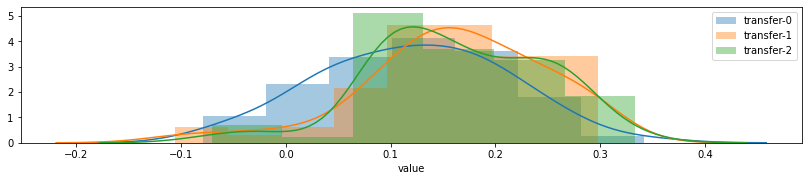

               value
model               
transfer-0  0.120479
transfer-1  0.161314
transfer-2  0.163835


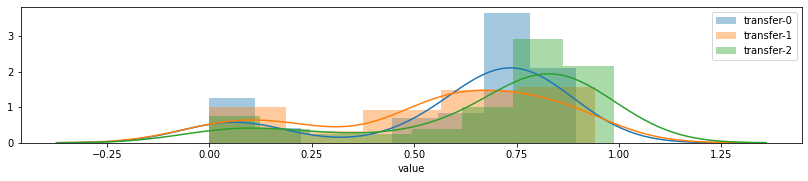

               value
model               
transfer-0  0.602438
transfer-1  0.550000
transfer-2  0.684813


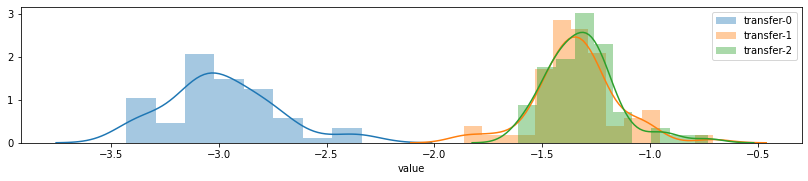

               value
model               
transfer-0 -2.988032
transfer-1 -1.342308
transfer-2 -1.317213


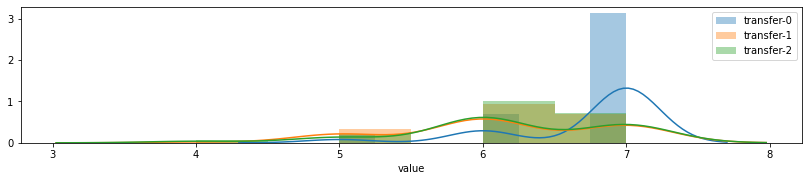

               value
model               
transfer-0  6.734375
transfer-1  6.140625
transfer-2  6.187500


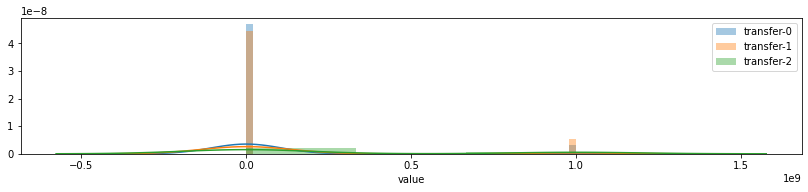

                   value
model                   
transfer-0  6.250000e+07
transfer-1  1.093750e+08
transfer-2  2.656250e+08


In [389]:
from trees import collect_score

# plot_and_print(compare(lambda d: d.mse, 'causal-best-tree', results), bins=20)
plot_and_print(r_squared(results))
plot_and_print(compare_cis(results))
plot_and_print(pick(lambda m: collect_score(m.model.tree), results))
plot_and_print(pick(lambda m: len(m.model.tree), results))
plot_and_print(pick(lambda d: d.model.feature_importance(gain=False)[1] / (d.model.feature_importance(gain=False)[0] + 1e-9), results))

In [379]:
%%time

params = {
    'N': 1000,
    'fn': lambda h,v,z,w: -w*h*(h > 0).astype(int) + 0.5*w*z*(z > 1).astype(int) + np.random.normal(0, 0.1, size = h.shape[0]),
    # 'fn': lambda h,v,z,w: -w*h + 0.5*w*z*(z < 3).astype(int) + np.random.normal(0, 0.5, size = h.shape[0]),
    # 'fn': lambda h,v,z,w: -w*h + 0.5*w*z + np.random.normal(0, 0.5, size = h.shape[0]),
    'hidden_cause': True,
    'hiddens': [(0,2)]*4,
    'v_conds': [(-0.5,0,1), (1,1,.5), (0.5,2,1), (-1,2,1)],
    'z_conds': [(2,2), (4,2), (6,2), (0,2)],
}


results = Parallel(n_jobs=-1)(delayed(runrun)(models, **params) for i in range(64))

CPU times: user 2.4 s, sys: 20.3 ms, total: 2.42 s
Wall time: 2min 29s


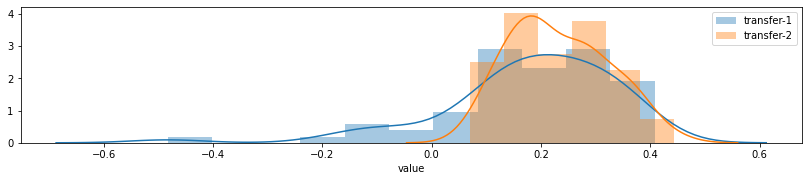

               value
model               
transfer-1  0.180432
transfer-2  0.233276


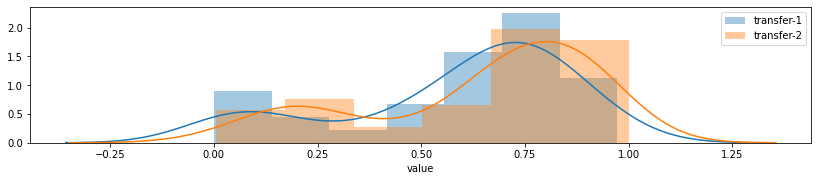

               value
model               
transfer-1  0.586937
transfer-2  0.644109


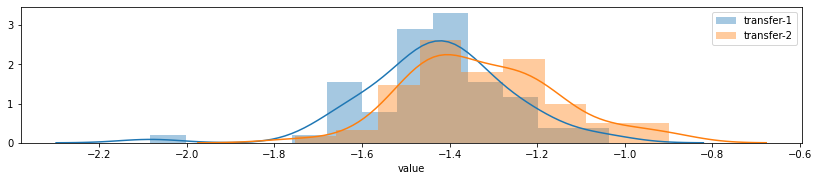

               value
model               
transfer-1 -1.427293
transfer-2 -1.323202


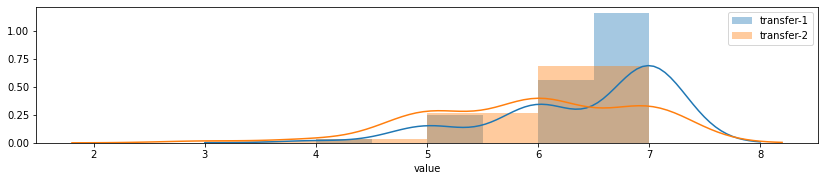

               value
model               
transfer-1  6.421875
transfer-2  5.937500


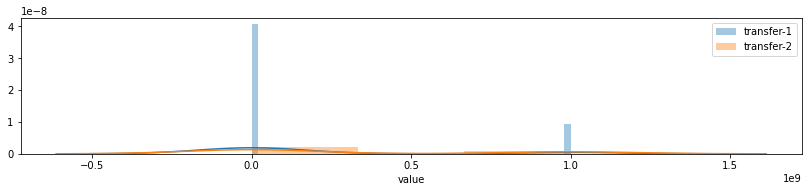

                   value
model                   
transfer-1  1.875000e+08
transfer-2  3.281250e+08


In [380]:
from trees import collect_score

# plot_and_print(compare(lambda d: d.mse, 'causal-best-tree', results), bins=20)
plot_and_print(r_squared(results))
plot_and_print(compare_cis(results))
plot_and_print(pick(lambda m: collect_score(m.model.tree), results))
plot_and_print(pick(lambda m: len(m.model.tree), results))
plot_and_print(pick(lambda d: d.model.feature_importance(gain=False)[1] / (d.model.feature_importance(gain=False)[0] + 1e-9), results))

In [375]:
%%time

params = {
    'N': 1000,
    'fn': lambda h,v,z,w: -w*h*(h > 0).astype(int) + 0.5*w*z*(z > 1).astype(int) + np.random.normal(0, 0.5, size = h.shape[0]),
    # 'fn': lambda h,v,z,w: -w*h + 0.5*w*z*(z < 3).astype(int) + np.random.normal(0, 0.5, size = h.shape[0]),
    # 'fn': lambda h,v,z,w: -w*h + 0.5*w*z + np.random.normal(0, 0.5, size = h.shape[0]),
    'hidden_cause': True,
    'hiddens': [(0,2)]*4,
    'v_conds': [(-0.5,0,1), (1,1,.5), (0.5,2,1), (-1,2,1)],
    'z_conds': [(2,2), (4,2), (6,2), (0,2)],
}


results = Parallel(n_jobs=-1)(delayed(runrun)(models, **params) for i in range(64))

CPU times: user 2.38 s, sys: 27 ms, total: 2.4 s
Wall time: 2min 30s


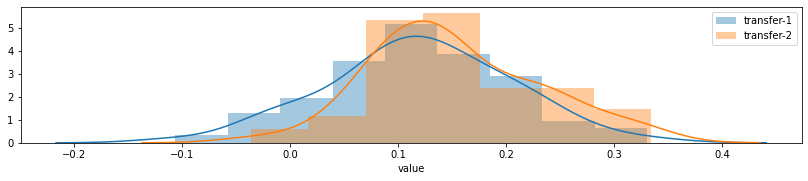

               value
model               
transfer-1  0.119336
transfer-2  0.152571


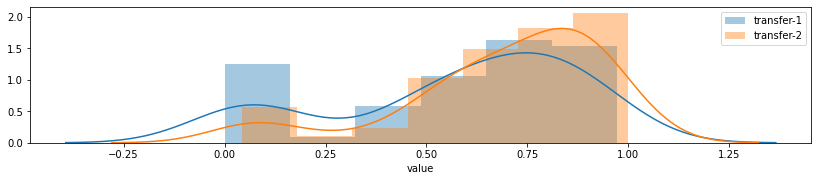

               value
model               
transfer-1  0.573437
transfer-2  0.694922


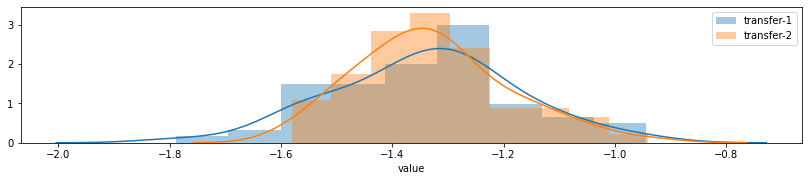

               value
model               
transfer-1 -1.339689
transfer-2 -1.328604


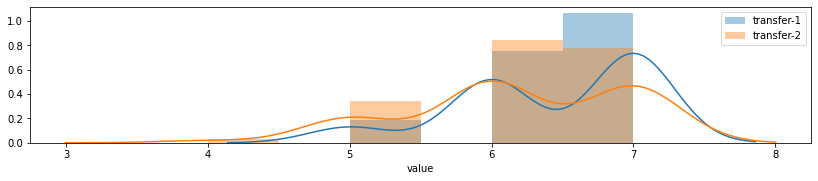

             value
model             
transfer-1  6.4375
transfer-2  6.1875


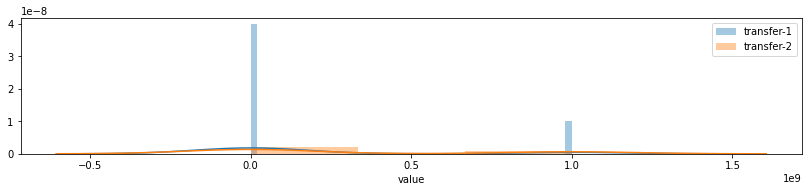

                   value
model                   
transfer-1  2.031250e+08
transfer-2  3.125000e+08


In [376]:
from trees import collect_score

# plot_and_print(compare(lambda d: d.mse, 'causal-best-tree', results), bins=20)
plot_and_print(r_squared(results))
plot_and_print(compare_cis(results))
plot_and_print(pick(lambda m: collect_score(m.model.tree), results))
plot_and_print(pick(lambda m: len(m.model.tree), results))
plot_and_print(pick(lambda d: d.model.feature_importance(gain=False)[1] / (d.model.feature_importance(gain=False)[0] + 1e-9), results))

In [ ]:
%%time

params = {
    'N': 1000,
    'fn': lambda h,v,z,w: -w*h + 0.5*w*z + np.random.normal(0, 0.5, size = h.shape[0]),
    'hidden_cause': True,
    'hiddens': [(0,2)]*4,
    'v_conds': [(0.5,0,1)]*4,
    'z_conds': [(2,2)]*4,
}

data_check(**params)
results = Parallel(n_jobs=-1)(delayed(runrun)(models, **params) for i in range(16))

In [ ]:
# imps = compare(lambda d: d.model.feature_importance(gain=False)[1], 'causal', results).groupby('model').mean()
# print(imps)
# plot_and_print(compare(lambda d: d.mse, 'causal-3', results), bins=20)
plot_and_print(r_squared(results))
plot_and_print(compare_cis(results))

In [ ]:
%%time

params = {
    'N': 1000,
    'fn': lambda h,v,z,w: -w*h + 0.5*w*z + np.random.normal(0, 0.5, size = h.shape[0]),
    'hidden_cause': True,
    'hiddens': [(0, 2), (2, 1), (3, 2), (4, 1)],
    'v_conds': [(-0.5,0,1), (1,1,.5), (0.5,2,1), (-1,2,1)],
    'z_conds': [(2,2), (4,2), (6,2), (0,2)],
}

data_check(**params)
results = Parallel(n_jobs=-1)(delayed(runrun)(models, **params) for i in range(32))

In [601]:
m = results[10][3].model

In [602]:
collect_score(m.tree)

-0.29096749509811065

In [603]:
scored = [(tree, alpha, collect_score(tree)) for alpha,tree in m.tree_path]
best_tree, best_alpha, best_score = sorted(scored, key=lambda t: t[2])[0]

best_alpha, best_score, 

(-0.12102256317837445, -0.29096749509811065)

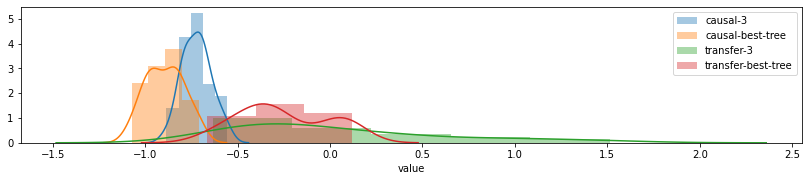

                       value
model                       
causal-3           -0.721635
causal-best-tree   -0.893612
transfer-3          0.034019
transfer-best-tree -0.253186


In [581]:
plot_and_print(pick(lambda m: collect_score(m.model.tree), results))

/home/jupyter/.local/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/jupyter/.local/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


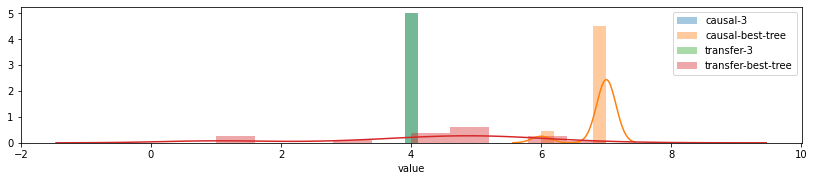

                      value
model                      
causal-3            4.00000
causal-best-tree    6.90625
transfer-3          4.00000
transfer-best-tree  4.25000


In [544]:
plot_and_print(pick(lambda m: len(m.model.tree), results))

In [ ]:
# def scores(results):
    # return [(collect_score(m.tree), m.model_name)]
    # collect_score(results[0][1].model.tree)    

In [537]:
# results[0][1].model.tree


-0.9089162015111771

In [535]:
from trees import collect_score

collect_score(results[0][3].model.tree)

-0.41004542653867987

In [521]:
# plot_and_print(r_squared(results))
# plot_and_print(compare_cis(results))

compare_cis(results)

,value,model
0,0.0,causal-3
1,0.0,causal-best-tree
2,0.0,transfer-3
3,0.0,transfer-best-tree
4,0.0,causal-3
...,...,...
123,0.0,transfer-best-tree
124,0.0,causal-3
125,0.0,causal-best-tree
126,0.0,transfer-3


# Causal Tree Test

In [50]:
from sklearn.model_selection import ParameterGrid
from copy import deepcopy

def make_nested_grid(params):
    return ParameterGrid({ key: list(ParameterGrid(value))
                           for key, value in params.items()})


def _crossval_score(model, X, y, treatment, weights, splitter, fit_params, init_params):
    model = deepcopy(model)
    model.set_params(**init_params)
    scores = []

    for train_idx, test_idx in splitter.split(X, treatment):
        model.fit(X[train_idx, :], 
                  y[train_idx], 
                  treatment = treatment[train_idx], 
                  sample_weight = weights[train_idx],
                  **fit_params)

        score = model.score(X[test_idx, :],
                            y[test_idx], 
                            treatment = treatment[test_idx], 
                            sample_weight = weights[test_idx],
                            **fit_params)
            
        scores.append(score)
    
    return np.mean(scores)

from joblib import Parallel, delayed

def model_search(model, X, y, treatment, weights, init_params, fit_params, splitter, n_jobs = -1):
    grid = make_nested_grid({'fit_params': fit_params, 
                             'init_params': init_params})

    all_scores = Parallel(n_jobs=n_jobs)(delayed(_crossval_score)(model, X, y, treatment, weights, splitter, **g) for g in grid)
    # all_scores = [_crossval_score(model, X, y, treatment, weights, splitter, **g) for g in grid]

    return list(zip(grid, all_scores))   

In [246]:
def eta(X):
    return 0.5 * X[:, 0] + X[:, 1]

def kappa(X):
    return 0.5 * X[:, 0]

def gen_y(X, w):
    return eta(X) + 0.5 * (2*w - 1) * kappa(X) + np.random.normal(0, 0.01)

N = 1000
S = round(N/2)
X = np.random.normal(0, 1, (N, 6))
treatment = np.random.binomial(1, 0.5, N)
y = gen_y(X, treatment)

In [247]:
# Dataset phi_source, phi_target (X)
# 

<function __main__.fit_model(model, dat: simulation.Dataset)>

In [51]:
from simulation import Dataset, Ctx

def eta(X):
    return 0.5 * np.sum(X[:, :2], axis=1) + np.sum(X[:, 2:], axis=1)

def kappa(X):
    return np.sum(X[:, :2] * (X[:, :2] > 0).astype(int), axis=1)

def gen_y(X, w):
    return eta(X) + 0.5 * (2*w - 1) * kappa(X) + np.random.normal(0, 0.01, size = X.shape[0])


def causal_trees_simulation(S, N):
    X = np.random.normal(0, 1, (N, 6))
    treatment = np.random.binomial(1, 0.5, N)
    weights = np.ones(N)
    taus = kappa(X)
    y = gen_y(X, treatment)

    split = lambda arr: (arr[:S], arr[S:])
    
    return Dataset(Ctx(*split(X)), Ctx(*split(y)), treatment[:S], np.zeros(S), Ctx(*split(taus)))


In [ ]:
sim_dat = pd.concat([pd.DataFrame(X, columns = range(1, 7)), 
                     pd.DataFrame({ 'y': y, 'treatment': treatment, 'tau': kappa(X)})], axis=1)

sim_dat.to_csv('sim_dat-2.csv', index=False)

In [376]:
# idx = np.arange(X.shape[0])
# np.random.shuffle(idx)

# treatment = treatment[idx]
# X = X[idx, :]
# y = y[idx]

In [ ]:
%%time

from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits = 3)

model = TransferTreeRegressor(criterion = causal_tree_criterion, 
                              min_samples_leaf = 10,
                              alpha = 0.1, 
                              honest = False)

fit_params = {'min_samples': [25] }
init_params = {'alpha': [ -.1, -0.05, -0.01, 0.0, 0.01, 0.05, 0.1, 0.4 ], 'honest': [True] }

results = model_search(model, X[:S], y[:S], treatment[:S], weights[:S], init_params, fit_params, cv)

best_params = sorted(results, key = lambda t: t[1])[0][0]['init_params']

best_params

In [52]:
models = [
    ('causal-tree', 
     TransferTreeRegressor(criterion = causal_tree_criterion, 
                           min_samples_leaf = 50,
                           alpha = None),

     lambda dat: {'X': dat.phi.source, 
                  'y':dat.y.source, 
                  'treatment': dat.treatment, 
                  'min_samples': 25,
                  'honest': True,
                  'var_weight': 0.5}),

    ('causal-tree-no-var', 
     TransferTreeRegressor(criterion = causal_tree_criterion, 
                           min_samples_leaf = 50,
                           alpha = None),

     lambda dat: {'X': dat.phi.source, 
                  'y':dat.y.source, 
                  'treatment': dat.treatment, 
                  'min_samples': 25,
                  'honest': True,
                  'var_weight': 0.0}),

    # ('transfer-tree', 
    #  TransferTreeRegressor(criterion = transfer, 
    #                        min_samples_leaf = 50,
    #                        alpha = None),

    #  lambda dat: {'X': dat.phi.source, 
    #               'y': dat.y.source, 
    #               'treatment': dat.treatment, 
    #               'min_samples': 25,
    #               'honest': True,
    #               'var_weight': 0.5, 
    #               'context_idxs': dat.context_idxs, 
    #               'target_X': dat.phi.target, 
    #               'importance': False})   
]

In [53]:
def run_causal_trees(models, **params):
    data = causal_trees_simulation(**params)
    return [fit_model(model, data) for model in models]

In [58]:
params = { 'S': 1000, 'N': 8000 }

results = Parallel(n_jobs=-1)(delayed(run_causal_trees)(models, **params) for i in range(32))

In [ ]:
plot_dist(pick(lambda m: m.r2, results))

In [ ]:
pick(lambda m: m.r2, results).groupby('model').mean()

In [ ]:
model = TransferTreeRegressor(criterion = mse, max_depth = 5, min_samples_leaf = 10)

model.fit(phi(X), y, sample_weight = weights)
preds = model.predict(phi(X))
# np.mean((preds - y)**2)

np.histogram(preds)

In [60]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10)

model.fit(phi(X), y, sample_weight = weights)
preds = model.predict(phi(X))
np.mean((preds - y)**2)

(array([  15,    0,   41,   23,   95,   47,   87,  103,  406, 1183]),
 array([-129.40835129, -116.21549089, -103.02263049,  -89.82977009,
         -76.63690969,  -63.44404929,  -50.25118889,  -37.05832849,
         -23.86546809,  -10.67260769,    2.52025272]))

In [34]:
model = DecisionTreeRegressor(max_depth=4, min_samples_leaf=20)

np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = True) for i in range(10)]), 0)

array([ 0.3661, 20.3762,  0.4404,  7.6768])

In [35]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = False) for i in range(10)]), 0)

array([ 0.3656, 41.3072, 15.5   ,  1.5563])

In [36]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = True) for i in range(10)]), 0)

array([11.7473, 32.487 , 11.613 ,  4.5725])

In [37]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = False) for i in range(10)]), 0)

array([12.42759, 25.75614,  5.67631,  3.50874])

In [38]:
model = TransferTreeRegressor(criterion=mse, max_depth=4, min_samples_leaf=20)

np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = True) for i in range(10)]), 0)

array([ 0.3661, 20.3762,  0.4404,  7.6768])

In [39]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = False) for i in range(10)]), 0)

array([ 0.3656, 41.3072, 15.5   ,  1.5563])

In [52]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = True) for i in range(10)]), 0)

array([11.3818, 32.1958, 11.2033,  3.5604])

In [51]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = False) for i in range(10)]), 0)

array([10.9098,  4.9235,  3.2745,  3.7268])

In [42]:
model = LinearRegression(fit_intercept=False)
run_model(dat, model, phi, 0, 1, use_weights = None, model_search = False)

[0.3605, 21.2762, 16.201, 7.1304]

In [31]:
run_model(dat, model, phi, 0, 3, use_weights = None, model_search = True)

[0.4141, 20.8479, 0.2354, 6.2956]

In [32]:
run_model(dat, model, phi, 0, 1, use_weights = 1, model_search = False)

[12.3876, 41.752, 16.8672, 4.4122]

In [33]:
run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = True)

[11.362, 31.8239, 11.2857, 4.7136]

In [1802]:
# get residuals for "sets" separately
# compute distance between residuals
# optimize squared errors + penalty for residual distance

# search for "sets" by looking at residuals and fitting a mixture model
# then optimize to remove that mixture...

# set up an adversarial problem: the adversary tries to find a 
# mixture model in your reiduals, the classifier tries to make force the
# adversary to fit a 1-component mixture, for example... 